In [15]:
import sys
sys.path.append('../')
from Attacked_Model.autoencoder_BATADAL_for_CNN import load_AEED
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, precision_score, recall_score
import pickle
from sklearn.preprocessing import MinMaxScaler
import numpy as np
att_data = pd.read_csv('../Data/BATADAL/attack_10_from_test_dataset.csv')

# define the column sets for the pandas dataframes
xset = [col for col in att_data.columns if col not in ['Unnamed: 0', 'DATETIME', 'ATT_FLAG']]
yset = ['ATT_FLAG']
model ='CNN'
autoencoder = load_AEED("../Attacked_Model/BATADAL/"+model+"/"+model+".json", "../Attacked_Model/BATADAL/"+model+"/"+model+".h5")
scaler = pickle.load(open("../Attacked_Model/BATADAL/"+model+"/scaler.p", "rb"))
with open("../Attacked_Model/BATADAL/"+model+"/theta") as f:
        theta = float(f.read())
import warnings
warnings.filterwarnings('ignore')

In [16]:
def compute_scores(Y, Yhat):
    return [accuracy_score(Y, Yhat), f1_score(Y, Yhat), precision_score(Y, Yhat), recall_score(Y, Yhat)]#, fpr[0]]

In [17]:
def create_dataset(dataset, window_size = 4):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size + 1)] #remove +1 to turn into 1-step ahead prediction
        data_X.append(a)
        data_Y.append(dataset[i + window_size])
    return(np.array(data_X), np.array(data_Y))

# Evaluate Constrained attack over X dimension

In [18]:
results_mean_replay = {new_list: 0 for new_list in [2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,43]}
#results_mean_white = {new_list: 0 for new_list in [2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,43]}
results_mean_black = {new_list: 0 for new_list in [2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,43]}
sum_orig = 0
results_orig = pd.DataFrame(
                           columns=['accuracy', 'f1_score', 'precision', 'recall'])#,'fpr'])
for i in range(1,15):
    df_test_01 = pd.read_csv('../Data/BATADAL/attack_'+str(i)+'_from_test_dataset.csv', parse_dates = ['DATETIME'], dayfirst=True)
    window = 1 
    X3 = pd.DataFrame(index=df_test_01.index, columns=xset,
                      data=scaler.transform(df_test_01[xset]))
    X3, Y3_target = create_dataset(X3.values, window)
    Y3 = [1]*len(Y3_target)
    Yhat3, _, = autoencoder.detect(X3, Y3_target, theta=theta, window=3, average=True)
    
    results_orig.loc['orig'+str(i)] = compute_scores(Y3, Yhat3)
    sum_orig = sum_orig + results_orig.loc['orig'+str(i)].at['accuracy']
    results_replay = {}
    #results_white = {}
    results_black = {}
    for max_concealeble_variables in [2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,43]:
            replay = pd.read_csv('../Adversarial_Attacks/Replay_Attack/results/BATADAL/attack_'+str(i)+'_replay_max_'+str(max_concealeble_variables)+
                                     '.csv', dayfirst=True)
            if not(max_concealeble_variables == 43):
                
                #white_box = pd.read_csv('../Adversarial_Attacks/Whitebox_Attack/results/BATADAL/max_constraints_fixed/whitebox_attack_'+str(i)+
                #                        '_from_test_dataset_max_'+str(max_concealeble_variables)+'.csv', dayfirst=True)
                black_box = pd.read_csv('../Adversarial_Attacks/Black_Box_Attack/results/BATADAL/AE_max_concealable_var_'+
                                        str(max_concealeble_variables)+
                                        '/new_advAE_attack_'+str(i)+'_from_test_dataset_max'+str(max_concealeble_variables)+'.csv', dayfirst=True)
            else:
                #white_box = pd.read_csv('../Adversarial_Attacks/Whitebox_Attack/results/BATADAL/new_improved_whitebox_attack_'+str(i)+'_from_test_dataset.csv', dayfirst=True)
                black_box = pd.read_csv('../Adversarial_Attacks/Black_Box_Attack/results/BATADAL/unconstrained_attack/new_advAE_attack_'+str(i)+'_from_test_dataset.csv', dayfirst=True)
            
            replay = pd.DataFrame(index=replay.index, columns=xset,
                      data=scaler.transform(replay[xset]))
            X_replay, Y_replay = create_dataset(replay.values, window)
            
            #white_box = pd.DataFrame(index=white_box.index, columns=xset,
            #          data=scaler.transform(white_box[xset]))
            #X_white_box, Y_white_box = create_dataset(white_box.values, window)
            
            black_box = pd.DataFrame(index=black_box.index, columns=xset,
                      data=scaler.transform(black_box[xset]))
            X_black_box, Y_black_box = create_dataset(black_box.values, window)
            
            Y5 = [1]*len(X_replay)
            #Y6 = [1]*len(X_white_box)
            Y7 = [1]*len(X_black_box)
            
            Yhat5, _, = autoencoder.detect(X_replay, Y_replay, theta=theta, window=3, average=True)
            #Yhat6, _, = autoencoder.detect(X_white_box, Y_white_box, theta=theta, window=3, average=True)
            Yhat7, _, = autoencoder.detect(X_black_box, Y_black_box, theta=theta, window=3, average=True)
            
            results = pd.DataFrame(
                           columns=['accuracy', 'f1_score', 'precision', 'recall'])#,'fpr'])
            results.loc['replay'] = compute_scores(Y5, Yhat5)
            #results.loc['iterative'] = compute_scores(Y6, Yhat6)
            results.loc['learning'] = compute_scores(Y7, Yhat7)
            
            results_replay[max_concealeble_variables] = results.loc['replay'].at['accuracy']
            #results_white[max_concealeble_variables] = results.loc['iterative'].at['accuracy']
            results_black[max_concealeble_variables] = results.loc['learning'].at['accuracy']  
            
            results_mean_replay[max_concealeble_variables] =  results_mean_replay[max_concealeble_variables] + results_replay[max_concealeble_variables]
            #results_mean_white[max_concealeble_variables] = results_mean_white[max_concealeble_variables] + results_white[max_concealeble_variables]
            results_mean_black[max_concealeble_variables] = results_mean_black[max_concealeble_variables] + results_black[max_concealeble_variables]

In [19]:
results_attack = pd.DataFrame(columns=[43, 40, 35, 30, 25, 20, 15, 10, 9, 8, 7, 6, 5, 4, 3, 2])
for j in [43, 40, 35, 30, 25, 20, 15, 10, 9, 8, 7, 6, 5, 4, 3, 2]:
    results_attack.loc['replay', j] = round(results_mean_replay[j]/14, 2)
    #results_attack.loc['iterative', j] = round(results_mean_white[j]/14, 2)
    results_attack.loc['learning', j] = round(results_mean_black[j]/14, 2)

In [20]:
print("Original Accuracy: "+str(round(sum_orig/14,2)))
print("Accuracy After Constrained Variables Adversarial Attack")
results_attack

Original Accuracy: 0.67
Accuracy After Constrained Variables Adversarial Attack


,43,40,35,30,25,20,15,10,9,8,7,6,5,4,3,2
replay,0,0.32,0.74,0.89,0.96,0.96,0.95,0.89,0.83,0.91,0.89,0.89,0.82,0.77,0.87,0.81
learning,0.18,0.2,0.39,0.39,0.39,0.39,0.4,0.38,0.39,0.35,0.4,0.48,0.5,0.5,0.57,0.56


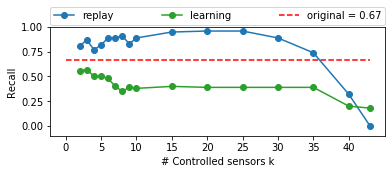

In [21]:
import matplotlib.pyplot  as plt
fig, ax = plt.subplots(figsize=(6,2))
ax.hlines(y=round(sum_orig/14,2),xmin=0, xmax=43, color='r', linestyles='--',)
colors = ['#1f77b4', '#2ca02c']
ax.set_prop_cycle('color',colors )
ax.plot(results_attack.transpose(), 'o-')
plt.legend(np.append(results_attack.transpose().columns.values, 'original = '+str(round(sum_orig/14,2))),bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=4, mode="expand", borderaxespad=0.)
plt.xticks(np.arange(0, 43, 5.0))
plt.ylim(-0.1,1.0)
plt.xlabel('# Controlled sensors k')
plt.ylabel('Recall')
plt.savefig('plot_recall_generizability_'+model+'_BATADAL.pdf', bbox_inches = "tight")
plt.show()

In [ ]:
results_attack.to_latex()